# **Applied AI in Biomedicine - Final Assignment**
## PAC/PVC classification from ECG signals
***
* Alberto Rota: *Person Code: 10615751 - Student Number: 964662 - [alberto2.rota@mail.polimi.it](mailto:alberto2.rota@mail.polimi.it)*  
* Gabriele Santicchi: *Person Code: 10579046 - Student Number: 969088 - [gabriele.santicchi@mail.polimi.it](mailto:gabriele.santicchi@mail.polimi.it)*
***

In [74]:
#@title Set up the environment
import os
import numpy as np, os, sys, joblib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rc('font', family='serif') 
mpl.rc('font', serif='Computer Modern Roman') 
import seaborn as sns
import tarfile
import math
import random
import sklearn
import timeit
import json
import warnings
import random

import scipy
from scipy.io import loadmat
from random import randint

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers


from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing 

SEED = 69
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("Using Tensorflow version",tf.__version__)
print("RNG seed:", SEED)

Using Tensorflow version 2.6.0
RNG seed: 69


## Data loading

In [75]:
dataset_dir = "C:\\Users\\alber\\Desktop\\Files\\Università\\V ANNO ACCADEMICO\\AI in Biomedicine\\Workshop\\PAC-PVC-Beat-Classifier-for-ECGs\\data"

In [295]:
class Patient:
    def __init__(self,init_dict):
        self.path=init_dict['path']
        self.fs=init_dict['fs']
        self.id=init_dict['id']
        self.samples=init_dict['samples']
        self.lead1=init_dict['lead1']
        self.lead2=init_dict['lead2']
        self.rpeaks=init_dict['rpeaks']
        self.peaklabels=init_dict['peaklabels']
        
    def info(self):
        print(">> ID:",self.id)
        print("   Path:",self.path)
        print("   fs:",self.fs)
        print("   samples:",self.samples)
        print("   lead1:",self.lead1)
        print("   lead2:",self.lead2)
        print("   rpeaks:",self.rpeaks)
        print("   peaklabels:",self.peaklabels)
        
    def plot(self,windowstart=None,xrange=4000):
        if windowstart is None: windowstart = randint(0,self.samples-xrange)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(np.arange(0,self.samples/self.fs,1/self.fs),self.lead1,color='#073b4c')
        plt.scatter(self.rpeaks[self.peaklabels=='N']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='N']],color='#06d6a0',s=500,alpha=0.5,label="Normal")
        plt.scatter(self.rpeaks[self.peaklabels=='S']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='S']],color='#ef476f',s=500,alpha=0.5,label="SopraVentricular")
        plt.scatter(self.rpeaks[self.peaklabels=='V']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='V']],color='#ffd166',s=500,alpha=0.5,label="Ventricular")
        plt.grid(True)
        plt.xlim([windowstart/self.fs,(windowstart+xrange)/self.fs])
        plt.title("ECG lead 1")
        plt.xlabel("Time [seconds]")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
        
        plt.figure(figsize=(10,2.5))
        plt.plot(np.arange(0,self.samples/self.fs,1/self.fs),self.lead2,color='#073b4c')
        plt.scatter(self.rpeaks[self.peaklabels=='N']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='N']],color='#06d6a0',s=500,alpha=0.5,label="Normal")
        plt.scatter(self.rpeaks[self.peaklabels=='S']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='S']],color='#ef476f',s=500,alpha=0.5,label="SopraVentricular")
        plt.scatter(self.rpeaks[self.peaklabels=='V']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='V']],color='#ffd166',s=500,alpha=0.5,label="Ventricular")
        plt.grid(True)
        plt.xlim([windowstart/self.fs,(windowstart+xrange)/self.fs])
        plt.title("ECG lead 2")
        plt.xlabel("Time [seconds]")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    # Aggiungere parametro width,
    def split_windows(self,borders=0.05):
        border_samples = round(borders*(self.rpeaks[0]))
        wl1 = [self.lead1[0:(self.rpeaks[0]-border_samples)]]
        wl2 = [self.lead1[0:(self.rpeaks[0]-border_samples)]]
        for p in range(1,self.rpeaks.shape[0]-1):
            border_samples = round(borders*(self.rpeaks[p+1]-self.rpeaks[p-1]))
            window = self.lead1[(self.rpeaks[p-1]+border_samples):(self.rpeaks[p+1]-border_samples)]
            wl1.append(window)
            window = self.lead2[(self.rpeaks[p-1]+border_samples):(self.rpeaks[p+1]-border_samples)]
            wl2.append(window)
        
        border_samples = round(borders*(self.rpeaks[0]))
        wl1.append(self.lead1[self.rpeaks[-1]:self.samples])
        wl2.append(self.lead1[self.rpeaks[-1]:self.samples])
        return wl1,wl2
        

In [296]:
files = os.listdir(dataset_dir)
p = []
correct,ncorrect=0,0
for f in range(0,len(files),3):
    try:
        recs = loadmat(os.path.join("data",files[f]))
        ann = loadmat(os.path.join("data",files[f+1]))
        rp =loadmat(os.path.join("data",files[f+2]))
        patient_as_dict={
                'id':files[f].split(".")[0].split("_")[0],
                'path':os.path.join("data",files[f]),
                'fs':float(files[f].split(".")[0].split("_")[1]),
                'samples':recs['ecg'][:,0].shape[0],
                'lead1':recs['ecg'][:,0],
                'lead2':recs['ecg'][:,1],
                'rpeaks':rp['rpeaks'].T[0],
                'peaklabels':ann['labels'] 
        }
        p.append(Patient(patient_as_dict))
        correct+=1
        
    except:
        ncorrect+=1
print(f"Loaded {correct} files correctly")
if ncorrect>0: print(f"!!!! Error in loading {ncorrect} files")

Loaded 105 files correctly


### Example of R-peaks labelling

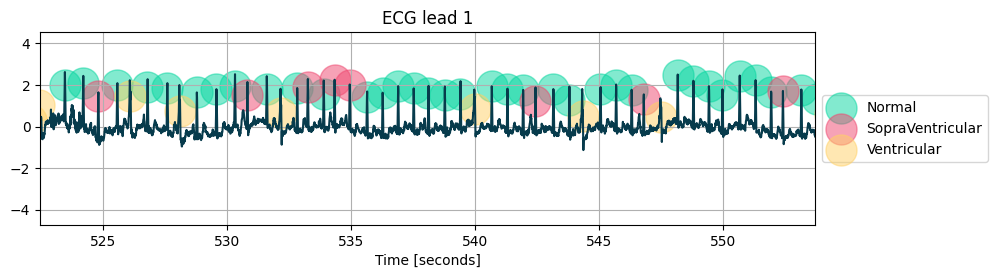

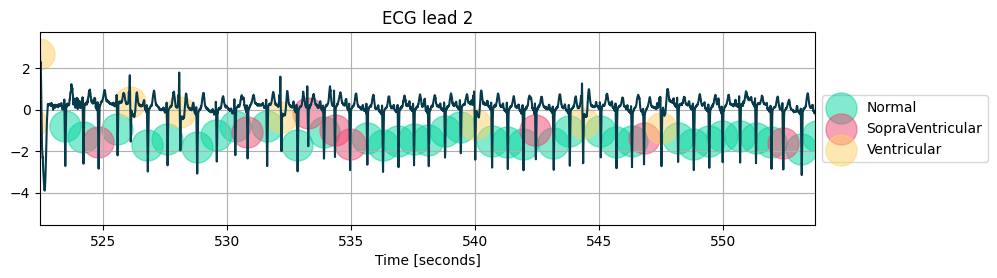

In [302]:
p[9].plot()

>> ID: S039
   Path: data\S039_128.mat
   fs: 128.0
   samples: 230400
   lead1: [-0.2  -0.23 -0.24 ... -0.36 -0.38 -0.43]
   lead2: [0.08 0.1  0.08 ... 0.26 0.28 0.27]
   rpeaks: [    86    187    292 ... 230161 230266 230371]
   peaklabels: ['N' 'N' 'N' ... 'N' 'N' 'N']


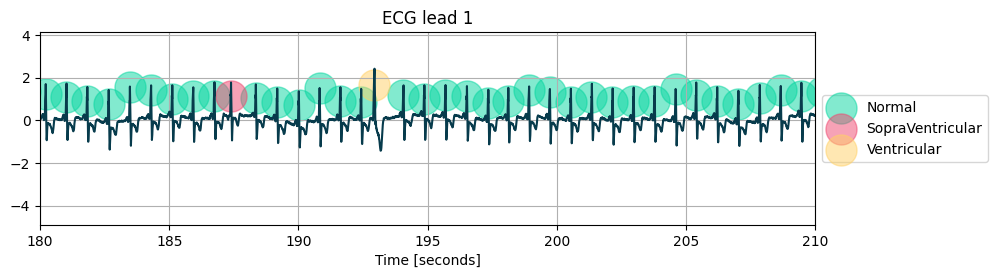

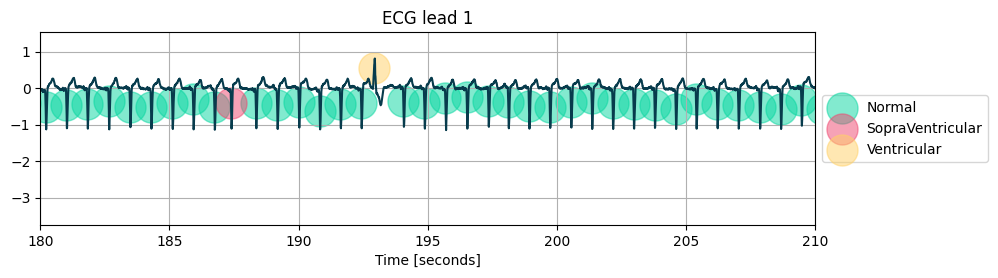

In [272]:
p[38].info()
p[38].plot(180*p[38].fs,30*p[38].fs)

In [ ]:
for pa in p: print(pa.samples, pa.fs,pa.samples/pa.fs, ) 

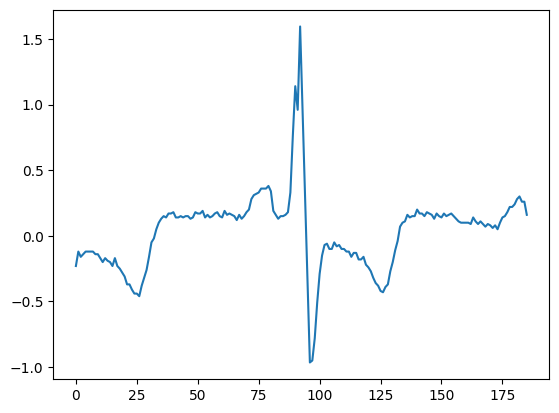

In [303]:
split1,split2 = pt.split_windows(borders=0.05)
plt.plot(split1[0])
plt.show()

Preprocessing:
* numpy Interp1D per upsampling/downsampling
* Controllo NaN  e Outliers
* (Rescale su singola finestra)
* Cosa fare con finestre di different lenght?
Modelli: